# **CIS 4190/5190 - AdaBoost, XGBoost, PCA**

In [1]:
# Restart the runtime after running this cell everytime you open the notebook
!pip install pandas==1.1.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 37.3 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 1.4.4
    Uninstalling pandas-1.4.4:
      Successfully uninstalled pandas-1.4.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
xarray 2022.12.0 requires pandas>=1.3, but you have pandas 1.1.5 which is incompatible.
plotnine 0.10.1 requires pandas>=1.3.5, but you have pandas 1.1.5 which is incompatible.
mizani 0.8.1 requires pandas>=1.3.5, but you have pandas 1.1.5 which is incompatible.
arviz 0.15.1 requires pandas>=1.3.0, but you have pandas 1.1.5 which is incompatible.


In [2]:
!pip install dill

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 KB 3.7 MB/s eta 0:00:00


In [3]:
import random 
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
from numpy.linalg import *
from scipy.spatial import distance
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
np.random.seed(42)  # don't change this line

import base64
import datetime

In [4]:
a = np.array([[2,3],[4,5]])
a[:,1] = [77,67]
print(a)

[[ 2 77]
 [ 4 67]]


In [5]:
# For autogreader only, do not modify this cell. 
# True for Google Colab, False for autograder
NOTEBOOK = (os.getenv('IS_AUTOGRADER') is None)
if NOTEBOOK:
    print("[INFO, OK] Google Colab.")
else:
    print("[INFO, OK] Autograder.")

[INFO, OK] Google Colab.


## Datasets
Next, we will download the dataset from Google Drive to your local runtime. After successful download, you may verify that all datasets are present in your colab instance.

- [observations.csv](https://drive.google.com/file/d/1RvNTrL147Cx90ABv4IfXcexaRyHB-U-e/view?usp=sharing)
- [test_student.csv](https://drive.google.com/file/d/1EjQ3Jy5q25GaxeNKh4ahtsLgHEyW3tUj/view?usp=sharing)


#### Acknowledgement
Dataset obtained from kaggle.com [Hourly Weather Surface - Brazil (Southeast region)](https://www.kaggle.com/PROPPG-PPG/hourly-weather-surface-brazil-southeast-region/metadata )

In [18]:
if NOTEBOOK:
  import gdown
  if not os.path.exists("observations.csv"):
    !gdown --id 1RvNTrL147Cx90ABv4IfXcexaRyHB-U-e
  if not os.path.exists("test_student.csv"):
    !gdown --id 1Z0I6iylDgTk2OKuKDaQVR9I1aJvgRsn_

#### **NOTE 1. If you are running into a `__builtins__' error, it's likely because you're using a function call of the form numpy.ndarray.mean(), like a.mean(). This does not play nice with PennGrader unfortunately. Please use the function call numpy.mean(a) instead.**

In [19]:
def prepare_final_cleaned_df(df):
  df = df.drop(["Unnamed: 0"], axis=1)
  df["mdct"] = pd.to_datetime(df["mdct"])
  df.loc[df["gust"].isna(),"gust"] = 0
  df.loc[df["gbrd"].isna(),"gbrd"] = 0
  df.loc[df["wdsp"].isna(),"wdsp"] = 0
  df.loc[df["dewp"].isna(),"dewp"] = 0
  df.loc[df["dmin"].isna(),"dmin"] = 0
  df.loc[df["dmax"].isna(),"dmax"] = 0
  df = df[df["temp"] != 0]
  df = df.drop(columns=["prcp"])

  left_df = df.copy()
  right_df = df.copy()
  right_df["mdct"] = right_df["mdct"].apply(lambda x : x + datetime.timedelta(hours=1))

  columns = ["stp", "smax", "smin", "gbrd", "dewp", "tmax", 
            "dmax", "tmin", "dmin", "hmdy", "hmax",
            "hmin", "wdsp", "wdct", "gust", "temp"]
          
  merged_df = pd.merge(left_df, right_df, "left", on=["wsid","mdct"], indicator=True)
  merged_df = merged_df[merged_df['_merge'] == "both"]

  columns_x = [x + "_x" for x in columns]
  columns_y = [x + "_y" for x in columns]
  
  merged_df[columns] = merged_df[columns_x].values - merged_df[columns_y].values
  merged_df = merged_df.drop(columns=columns_x)
  merged_df = merged_df.drop(columns=columns_y)
  merged_df = merged_df.drop(columns=["_merge", "mdct", "wsid"])

  final_cleaned_df = merged_df.copy()

  final_cleaned_df.loc[final_cleaned_df["temp"] >= 0, "temp" ] = 1
  final_cleaned_df.loc[final_cleaned_df["temp"] < 0, "temp" ] = 0
  return final_cleaned_df

# **1. AdaBoost**

## **1.1.  [3 pts] Logistic regression with sample weights**

As you will have learnt from the lectures, AdaBoost fits weak learners (here, logistic regression model)  in each iteration, to a dataset with weights $w_i$ attached to each sample $(x_i, y_i)$. The loss function now becomes:

> $
\mathcal{L}({\theta}) = -\sum_{i =1}^N w_{i} \times [ y_i\log(h_{{\theta}}({x}_i)) + (1 - y_i)\log(1 - h_{{\theta}}({x}_i))]
$

where $h_\theta(x)$ is the logistic regression hypothesis function.

The gradient of this weighted loss function with respect to the weight $\theta_j$ is given by:

> $\frac{\partial \mathcal{L}({\theta})}{\partial \theta_j} = \sum_{i=1}^{N}w_{i}(h_{{\theta}}({x}_i) - y_i)x_{ij}$

Using this information, complete the `compute_gradient` method in the `LogisticRegression` class to account for sample weights.

In [20]:
class LogisticRegression:
    """
    Logistic Regression (aka logit, MaxEnt) classifier.

    Parameters
    ----------
    alpha: float, default=0.1
        Learning rate
    tol : float, default=0.01
        Tolerance for stopping criteria
    max_iter : int, default=1000
        Maximum number of iterations of gradient descent

    Attributes
    ----------
    theta_ : numpy.ndarray of shape (D + 1,)
        The value of the coefficients after gradient descent has converged
        or the number of iterations hit the maximum limit
    converged_: boolean
        Boolean value indicating whether gradient descent converged or not
    """

    def __init__(self, alpha=0.1, tol=0.01, max_iter=1000):

        self.alpha = alpha
        self.tol = tol
        self.max_iter = max_iter

        self.theta_ = None
        self.converged_ = False

    def compute_gradient(self, theta, X, y, sample_weight):
        """
        Compute the gradient of the cost function.

        Parameters
        ----------
        theta: numpy.ndarray of shape (D + 1,)
            The coefficients
        X: numpy.ndarray of shape (N, D + 1)
            The features matrix
        y: numpy.ndarray of shape (N,)
            The target variable array
        sample_weight: numpy.ndarray of shape (N,)
            The sample weight array

        Returns
        -------
        gradient: numpy.ndarray of shape (D + 1,)
            The gradient values
        """

        sigmoid = lambda x: 1 / (1 + np.exp(-x))
        y_hat = sigmoid(X.dot(theta))

        # STUDENT TODO: Compute the gradient
        gradient=[]
        for j in range(X.shape[1]):
          gradient_j = np.sum(sample_weight*(y_hat-y)*X[:,j])
          gradient = np.append(gradient, gradient_j)
        return gradient
        
        # STUDENT TODO END

    def fit(self, X, y, sample_weight):
        """
        Compute the coefficients using gradient descent and store them as theta_.

        Parameters
        ----------
        X: numpy.ndarray of shape (N, D)
            The features matrix
        y: numpy.ndarray of shape (N,)
            The target variable array
        sample_weight: numpy.ndarray of shape (N,)
            The sample weight array

        Returns
        -------
        Nothing
        """

        N, D = X.shape

        # Adding a column of ones at the beginning for the bias term
        ones_col = np.ones((N, 1))
        X = np.hstack((ones_col, X))

        # Initializing the weights
        theta_old = np.zeros((D + 1,))
        theta_new = theta_old.copy()

        for i in range(self.max_iter):
            theta_new = theta_old - self.alpha * self.compute_gradient(theta_old, X, y, sample_weight)

            if np.linalg.norm(theta_new - theta_old) / (np.linalg.norm(theta_old) + self.tol) <= self.tol:
                self.converged_ = True
                break
            
            theta_old = theta_new.copy()

        self.theta_ = theta_new

    def predict_proba(self, X):
        """
        Predict the probabilities that the data points in X belong to class 1.

        Parameters
        ----------
        X: numpy.ndarray of shape (N, D)
            The features matrix

        Returns
        -------
        y_hat: numpy.ndarray of shape (N,)
            The predicted probabilities that the data points in X belong to class 1
        """

        N = X.shape[0]
        
        # Adding a column of ones at the beginning for the bias term
        ones_col = np.ones((N, 1))
        X = np.hstack((ones_col, X))

        sigmoid = lambda x: 1 / (1 + np.exp(-x))
        y_hat = sigmoid(X.dot(self.theta_))
        return y_hat

    def predict(self, X):
        """
        Predict the classes of the data points in X.

        Parameters
        ----------
        X: numpy.ndarray of shape (N, D)
            The features matrix

        Returns
        -------
        y_pred: numpy.ndarray of shape (N,)
            The predicted class of the data points in X
        """

        y_hat = self.predict_proba(X)
        y_pred = y_hat.copy()
        y_pred[y_pred >= 0.5] = 1
        y_pred[y_pred < 0.5] = 0
        return y_pred

### Test case for the `compute_gradient` method

In [21]:
def test_compute_gradient(StudentLogisticRegression):
    
    student_lr_clf = StudentLogisticRegression()
    np.random.seed(0)
    theta_tc = np.random.randn(2)
    X_tc = np.random.randn(100, 2)
    y_tc = np.random.randint(0, 2, 100)
    sample_weight_tc = np.random.uniform(0, 1, 100)
    student_ans = student_lr_clf.compute_gradient(theta_tc, X_tc, y_tc, sample_weight_tc)
    required_ans = np.array([12.903225675830651, -1.0829605960182223])
    
    assert np.linalg.norm(student_ans - required_ans) < 1e-2 * required_ans.size

if NOTEBOOK:
    test_compute_gradient(LogisticRegression)

In [22]:
# PennGrader Grading Cell
if NOTEBOOK:
    grader.grade(test_case_id = 'test_compute_gradient_autograder', answer = grader_serialize(LogisticRegression))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## **1.2. [20 pts] AdaBoostClassifier Implementation**

In this section, you will be implementing the AdaBoost classifier with the logistic regression weak learner from above.

### **1.2.1. [12 pts] Follow the hints in the `fit` method in the `AdaBoostClassifier` class to implement the following algorithm.**

Use the following Adaboost pseudocode as a reference.

**INPUT:**

1. training data $X, y = \{(x_{i}, y_{i})\}_{i=1}^N$

2. number of iterations $T$

**ALGORITHM:**

1.   Initialize $N$ uniform weights, i.e., $w_{1} = [1/N, 1/N, ..., 1/N]$

2.   `For` $t = 1, 2, ... T$:

> 2.1. Train model $h_t$ on $X$ and $y$ with instance weights $w_{t}$

> 2.2. Compute the weighted training error rate of $h_{t}$: $\epsilon_{t} = \sum_{i: y_i \ne h_t(x_i)} w_{t,i}$

> 2.3. If $\epsilon_{t} > 0.5$, flip $h_t$'s predictions

> 2.4. Set $\beta_{t} = \frac{1}{2}\text{ln}\left(\frac{1 - \epsilon_t}{\epsilon_t}\right)$

> 2.5. Update all instance weights: $w_{t + 1,i} = w_{t,i}\times\text{exp}(-\beta_{t}y_{i}h_{t}(x_{i}))$ $\forall i = 1, 2, ..., N$

> 2.6. Normalize $w_{t+1}$ such that the elements sum to 1

> `End For`

### **1.2.2. [8 pts] Follow the hints in the `predict` method in the `AdaBoostClassifier` class for obtaining the predictions of the trained AdaBoost classifier.**

> $H(x) = \text{sign}\left(\sum_{t=1}^{T}\beta_{t}h_{t}(x)\right)$

In [23]:
class AdaBoostClassifier:
    """
    AdaBoost classifier based on logistic regression

    Parameters
    ----------
    T: int, default=100
        The number of logistic regression models in the boosting model

    Attributes
    ----------
    beta_arr_ : list of length T
        The list of beta values in the boosting model

    h_arr_: list of length T
        The list of logistic regression models in the boosting model
    """

    def __init__(self, T=100):

        self.T = T

        self.beta_arr_ = []
        self.h_arr_ = []

    def fit(self, X, y):
        """
        Train the logistic regression models (h) and compute their coefficients (beta), 
        and store them in h_arr_ and beta_arr_ respectively.

        Parameters
        ----------
        X: numpy.ndarray of shape (N, D)
            The features matrix
        y: numpy.ndarray of shape (N,)
            The target variable array

        Returns
        -------
        Nothing
        """

        N = X.shape[0]

        # STUDENT TODO: Initialize w with appropriate values
        w = np.full((N,),1/N)
        # STUDENT TODO END

        y_ = y.copy()
        # STUDENT TODO: Update y_ such that the 0's in y_ are replaced by -1
        y_[y_==0] = -1
        # STUDENT TODO END

        for t in range(self.T):
            h = LogisticRegression()
            # STUDENT TODO: 
            # Fit h to X and y using w as the sample weights
            h.fit(X,y,w)
            # Obtain the predictions from h and compute epsilon
            y_pred = h.predict(X)
            filter = y_pred!=y
            epsilon = np.sum(w[filter])
            print(epsilon)
            # If epsilon > 0.5:
            # 1. flip the predictions, i.e., replace 1's with 0's and 0's with 1's
            # 2. invert the model (h), i.e., make it predict 1 for what it predicted 0 earlier and vice-versa (clue: think about modifying h.theta_)        
            if epsilon > 0.5:
              y_pred=np.abs(y_pred-1)
              h.fit(X,-y,w)
            # STUDENT TODO END

            self.h_arr_.append(h)

            if epsilon == 0:
                beta = np.inf
                self.beta_arr_.append(beta)
                break
            
            # STUDENT TODO: Compute beta
            beta = 0.5*np.log((1-epsilon)/epsilon)
            # STUDENT TODO END

            self.beta_arr_.append(beta)
            y_pred_ = y_pred.copy()

            # STUDENT TODO: 
            # Update y_pred_ such that the 0's in y_pred_ are replaced by -1
            y_pred_[y_pred_==0] = -1
            # Update w and normalize it such that the values in w sum to 1
            Z = np.sum(w*np.exp(-beta*y_*y_pred_))
            w = w*np.exp(-beta*y_*y_pred_)/Z
            # STUDENT TODO END

    def predict(self, X):
        """
        Predict the classes of the data points in X.

        Parameters
        ----------
        X: numpy.ndarray of shape (N, D)
            The features matrix

        Returns
        -------
        y_pred: numpy.ndarray of shape (N,)
            The predicted class of the data points in X
        """
        
        N = X.shape[0]
        
        # Initialize the summation of beta times h for each x_i 
        sum_beta_times_h = np.zeros((N,))

        for t in range(len(self.h_arr_)):
            
            # STUDENT TODO: 
            # Obtain the predictions of the t-th model in self.h_arr_
            pred = self.h_arr_[t].predict(X)
            # Replace the 0's in the array with -1
            pred_ = pred.copy()
            pred_[pred_==0] = -1
            # Update sum_beta_times_h
            sum_beta_times_h = sum_beta_times_h + np.abs(self.beta_arr_[t])*pred_

        # Create an array `y_pred` for the final predictions
        # Fill 0's and 1's in `y_pred` depending on the sum_beta_time_h value in the corresponding location
        y_pred = np.sign(sum_beta_times_h)
        y_pred[y_pred==-1] = 0
        return y_pred
        # STUDENT TODO END


### Test case for the `fit` method

In [24]:
def test_adaboost_fit(StudentAdaBoostClassifier):

    T = 4
    N = 100
    D = 2

    student_ab_clf = StudentAdaBoostClassifier(T=T)
    np.random.seed(0)
    X_tc = np.random.randn(N, D)
    y_tc = np.random.randint(0, 2, N)
    student_ab_clf.fit(X_tc, y_tc)

    beta_arr_student_ans = student_ab_clf.beta_arr_
    beta_arr_required_ans = np.array([0.08017132503758954, 0.046732864002838985, 
                                      0.022808008179707476, 0.07012335626140642])
    assert np.linalg.norm(beta_arr_student_ans - beta_arr_required_ans) < 1e-2 * beta_arr_required_ans.size

    h_arr_student_ans = np.zeros([T, D + 1])

    for indx, h in enumerate(student_ab_clf.h_arr_):
        h_arr_student_ans[indx] = h.theta_

    h_arr_required_ans = np.array([[-0.01514967, -0.01713051,  0.21344566],
                                   [-0.01738886, -0.00656722,  0.12035635],
                                   [-0.0132557,  -0.00428943, 0.06616284],
                                   [-0.01037174, -0.00334141,  0.03943088]])

    assert np.linalg.norm(h_arr_student_ans - h_arr_required_ans) < 1e-2 * h_arr_required_ans.size

if NOTEBOOK:
    test_adaboost_fit(AdaBoostClassifier)

0.4600000000000001
0.47665056360708513
0.4885979729729731
0.4649956784788245


In [25]:
# PennGrader Grading Cell
if NOTEBOOK:
    grader.grade(test_case_id = 'test_adaboost_fit_autograder', answer = (grader_serialize(LogisticRegression), grader_serialize(AdaBoostClassifier)))

Correct! You earned 12/12 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### Test case for the `predict` method

In [26]:
def test_adaboost_predict(StudentAdaBoostClassifier):

    T = 4
    N = 100
    D = 2

    student_ab_clf = StudentAdaBoostClassifier(T=T)
    np.random.seed(0)
    X_tc = np.random.randn(N, D)
    y_tc = np.random.randint(0, 2, N)
    student_ab_clf.fit(X_tc, y_tc)

    student_ans = student_ab_clf.predict(X_tc)
    print(student_ans)
    required_ans = [1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 
                    0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 
                    1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 
                    0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 
                    1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1]

    assert np.mean(student_ans == required_ans) >= 0.98

if NOTEBOOK:
    test_adaboost_predict(AdaBoostClassifier)

0.4600000000000001
0.47665056360708513
0.4885979729729731
0.4649956784788245
[1. 1. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 0. 0. 1. 0. 1.
 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1.
 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1.
 0. 0. 1. 1.]


In [27]:
# PennGrader Grading Cell
if NOTEBOOK:
    grader.grade(test_case_id = 'test_adaboost_predict_autograder', answer = (grader_serialize(LogisticRegression), grader_serialize(AdaBoostClassifier)))

Correct! You earned 8/8 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## **1.3. [2 pts] AdaBoost on the dataset**

Follow the hints in the `adaboost_on_dataset` method in the below cell to run `AdaBoostClassifier` on the dataset.

In [28]:
# Load Dataset
df = pd.read_csv("observations.csv")
final_cleaned_df = prepare_final_cleaned_df(df)

In [29]:
if NOTEBOOK:
    test_df = pd.read_csv("test_student.csv").drop(columns=["Unnamed: 0"])

def adaboost_on_dataset():
    """
    Trains the AdaBoostClassifier on a real-world dataset.

    Parameters
    ----------
    Nothing

    Returns
    -------
    y_test_pred: numpy.ndarray
        The predicted classes of the datapoints in test_df
    """

    # STUDENT TODO START: Initialize X_train and y_train with appropriate values (clue: use .iloc followed by .values of the DataFrame class)
    X_train = final_cleaned_df.iloc[:,:-1].values
    y_train = final_cleaned_df.iloc[:, -1].values

    # STUDENT TODO END

    # STUDENT TODO START: Initialize X_test
    X_test = test_df
    # STUDENT TODO END
    
    scaler = StandardScaler()
    # STUDENT TODO START: Scale the features of X_train and X_test using scaler
    
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    # STUDENT TODO END

    clf = AdaBoostClassifier(T=10)
    # STUDENT TODO START: Now fit clf to the entire training data, i.e., X_train and y_train after feature scaling
    clf.fit(X_train_scaled, y_train)
    # STUDENT TODO END

    # STUDENT TODO START: Predict the classes of the datapoints in X_test and return the result
    predict = clf.predict(X_test_scaled)
    return predict
    # STUDENT TODO END

In [30]:
# PennGrader Grading Cell
if NOTEBOOK:
    y_test_pred = adaboost_on_dataset()
    grader.grade(test_case_id = 'test_adaboost_on_dataset_autograder', answer = y_test_pred)

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


0.14944522162390056
0.23717332050795656
0.3081762587985957
0.38592465786250185
0.27113881578285226
0.3983784747086806
0.4064115875008076
0.4496857915129721
0.47467014919155515
0.48873067427904426
Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


# **2. XGBoost**

## TODOs for this section:
- You'll use xgboost library to build a classifier for the above problem. XGBoost is a popular library for gradient boosting, and you can find its documentation [here](https://xgboost.readthedocs.io/en/latest/). 
- You need to get at least 0.75 accuracy on the test set to receive full credits from the autograder.

In [31]:
if NOTEBOOK:
  train_df = final_cleaned_df.copy()
  test_df = pd.read_csv("test_student.csv").drop(columns=["Unnamed: 0"])

In [32]:
if NOTEBOOK:
    import xgboost as xgb
    
    # STUDENT TODO STARTS: 
    # 1. Fit an xgboost classifier to the training data (train_df, target variable is temp) 
    # 2. Obtain the predictions of the trained model on test_df in the variable y_test_pred
    # 3. Tune the hyperparameters such that you pass the autograder threshold accuracy of 0.75
    from xgboost import XGBClassifier
    X_train = train_df.iloc[:,:-1].values
    y_train = train_df.iloc[:, -1].values
    X_test = test_df
    bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')
    bst.fit(X_train, y_train)
    y_test_pred = bst.predict(X_test)
    # STUDENT TODO ENDS

In [33]:
# PennGrader Grading Cell
if NOTEBOOK:
    grader.grade(test_case_id = 'test_xgboost', answer = y_test_pred)

Correct! You earned 8/8 points. You are a star!

Your submission has been successfully recorded in the gradebook.


#**3. [25 pts, 15 autograded, 10 manually graded] K-means Clustering**

We will implement the k-means clustering algorithm using the Breast Cancer dataset. As with all unsupervised learning problems, our goal is to discover and describe some hidden structure in unlabeled data. The k-means algorithm, in particular, attempts to determine how to separate the data into <em>k</em> distinct groups over a set of features ***given that we know (are provided) the value of k***.

Knowing there are <em>k</em> distinct 'classes' however, doesn't tell anything about the content/properties within each class. If we could find samples that are representative of each of these *k* groups, then we could label the rest of the data based on how similar they are to each of the prototypical samples. We will refer to these representatives as the centroids (cluster centers) that correspond to each cluster.

## **3.1. Import the dataset**


In [34]:
if NOTEBOOK:
    from sklearn.datasets import load_breast_cancer
    cancer_dataset = load_breast_cancer()

    ## TODO your code here ##
    """
    First load the dataset X from cancer_dataset.
    X -  (m, n) -> m x n matrix where m is the number of training points = 569 and n is the no of features = 30
    """
    X = cancer_dataset['data']
    ...
    ## TODO end ##

## **3.2. [12 pts] K-means clustering implementation** 

We will first implement a class for k-means clustering.<br>
These are the main functions: <br>
- `__init__`: The initialiser/constructor (This is implemented for you)
- `fit`: Entrypoint function that takes in the dataset (X) as well as centroid initialisations and returns: 
    - the cluster labels for each row (data point) in the dataset
    - list of centroids corresponding to each cluster 
    - no of iterations taken to converge.

Inside fit() function, you will need to implement the actual kmeans functionality. <br>
The K-means process you should follow is listed below:
1. Initialize each of the k centroids to a random datapoint if initialisation is not provided.
2. Update each datapoint's cluster to that whose *centroid* is closest
3. Calculate the new *centroid* of each cluster
4. Repeat the previous two steps until no centroid value changes. Make sure you break out of the loop reagrdless of whether you converged or not once max iterations are reached.

To help streamline this process, three helper functions have been given to you in the KMeans class \
- compute_distance(): use for step-2 above
- find_closest_cluster(): use for step-2 above
- compute_centroid(): use for step-3 above


In [35]:
class KMeans:
    '''Implementing Kmeans clustering'''

    def __init__(self, n_clusters, max_iter=1000):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    def compute_centroids(self, X, clusters):
        """
        Computes new centroids positions given the clusters
        
        INPUT:
        X - m by n matrix, where m is the number of training points
        clusters -  m dimensional vector, where m is the number of training points 
                    At an index i, it contains the cluster id that the i-th datapoint 
                    in X belongs to.
        
        OUTPUT:
        centroids - k by n matrix, where k is the number of clusters.
        """
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        # TODO your code here
        for k in range(self.n_clusters):
          k_points = X[np.where(clusters == k)]
          centroids[k] = np.mean(k_points,axis=0)

        ## TODO end ##
        return centroids

    def compute_distance(self, X, centroids):
        """
        Computes the distance of each datapoint in X from the centroids of all the clusters
        
        INPUT:
        X - m by n matrix, where m is the number of training points
        centroids - k by n matrix, where k is the number of clusters
        
        OUTPUT:
        dist - m by k matrix, for each datapoint in X, the distances from all the k cluster centroids.
        
        """
        dist = np.zeros((X.shape[0], self.n_clusters))
        # TODO your code here
        for i in range(X.shape[0]):
          for k in range(self.n_clusters):
            dist[i][k] = np.linalg.norm(centroids[k]-X[i])

        ## TODO end ##
        return dist

    def find_closest_cluster(self, dist):
        """
        Finds the cluster id that each datapoint in X belongs to
        
        INPUT:
        dist - m by k matrix, for each datapoint in X, the distances from all the k cluster centroids.
        
        OUTPUT:
        clusters - m dimensional vector, where m is the number of training points 
                    At an index i, it contains the cluster id that the i-th datapoint 
                    in X belongs to.
        
        """
        clusters = np.zeros(dist.shape[0])
        # TODO your code here
        for i in range(dist.shape[0]):
          clusters[i] = np.where(dist[i]==min(dist[i]))[0]

        ## TODO end ##
        return clusters
    
    def fit(self, X, init_centroids=None):
        """
        Fit KMeans clustering to given dataset X. 
        
        INPUT:
        X - m by n matrix, where m is the number of training points
        init_centroids (optional) - k by n matrix, where k is the number of clusters
        
        OUTPUT:
        clusters - m dimensional vector, where m is the number of training points 
                    At an index i, it contains the cluster id that the i-th datapoint 
                    in X belongs to.
        centroids - k by n matrix, where k is the number of clusters. 
                    These are the k cluster centroids, for cluster ids 0 to k-1
        iters_taken - total iterations taken to converge. Should not be more than max_iter.
        
        """
        # Fix random seed. Do not change this!
        np.random.RandomState(111)

        ## TODO your code here ##
        # Initialise centroids to random points in the dataset if not provided (i.e. None)
        if init_centroids is None:
          index = random.sample(range(X.shape[0]),self.n_clusters)
          init_centroids = X[index]
        # Iterate until kmeans converges or max_iters is reached. In each iteration: 
        #  - Update each datapoint's cluster to that whose *centroid* is closest
        #  - Calculate the new *centroid* of each cluster
        #  - Repeat the previous two steps until no centroid value changes. 
        self.centroids = init_centroids.copy()
        iters_taken = 1
        self.clusters = []
        while iters_taken <= 100:
          dist = self.compute_distance(X,self.centroids)
          self.clusters = self.find_closest_cluster(dist)
          centroids_new = self.compute_centroids(X,self.clusters)
          if centroids_new is self.centroids:
            break
          else:
            self.centroids = centroids_new
            iters_taken = iters_taken + 1
        ## TODO end ##      
        return self.clusters, self.centroids, iters_taken

In [36]:
# test case centroids should be aroudn (1.5,1.5) and (4.5,4.5)
if NOTEBOOK:
  points = []
  result = []
  random.seed(0)
  for _ in range(500):
    x = random.random()*3
    y = random.random()*3
    points.append((x,y))
    result.append(0)
  for _ in range(500):
    x = random.random()*3 + 3
    y = random.random()*3 + 3
    points.append((x,y))
    result.append(1)
  clf = KMeans(2)
  points = np.asarray(points)

In [37]:
#test for sanity check
def test_compute_centroids():
  clf = KMeans(2)
  centroid_p = clf.compute_centroids(np.array(points),np.array(result))
  centroid_r = [[1.5185255, 1.45970038],
 [4.51568108,4.54138552]]
  assert(np.linalg.norm(centroid_p - np.array(centroid_r)) <= 1e-2 )
if NOTEBOOK:
  test_compute_centroids()

In [38]:
# PennGrader Grading Cell
if NOTEBOOK:
    grader.grade(test_case_id = 'test_compute_centroids', answer = grader_serialize(KMeans))

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [39]:
def test_distance():
    centroid_r = [[1.5185255, 1.45970038],
      [4.51568108,4.54138552]]
    clf = KMeans(2)
    distance = clf.compute_distance(np.array(points),np.array(centroid_r))
    distance_for_0 = [1.30098366, 3.01191447]
    assert(np.linalg.norm(distance_for_0-distance[0]) <= 1e-2)
if NOTEBOOK:
  test_distance()

In [40]:
# PennGrader Grading Cell
if NOTEBOOK:
    grader.grade(test_case_id = 'test_distance', answer = grader_serialize(KMeans))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [41]:
def test_find_clusters():
  centroid_r = [[1.5185255, 1.45970038],
      [4.51568108,4.54138552]]
  clf = KMeans(2)
  distance = clf.compute_distance(np.array(points),np.array(centroid_r))
  cluster = clf.find_closest_cluster(distance)
  assert(cluster[0] == 0)
if NOTEBOOK:
  test_find_clusters()

In [42]:
# PennGrader Grading Cell
if NOTEBOOK:
    grader.grade(test_case_id = 'test_find_clusters', answer = grader_serialize(KMeans))

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


In [43]:
def test_fit():
  clf = KMeans(2)
  clusters, centroids, _ = clf.fit(np.array(points),np.array([[1,1],[4,4]]))
  centroid_r = [[1.5185255, 1.45970038],
      [4.51568108,4.54138552]]
  assert(np.linalg.norm(centroids - np.array(centroid_r)) <= 1e-2 )
  assert(sum(np.array(clusters)-np.array(result)) == 0)
if NOTEBOOK:
  test_fit()

In [44]:
# PennGrader Grading Cell
if NOTEBOOK:
    grader.grade(test_case_id = 'test_fit', answer = grader_serialize(KMeans))

Correct! You earned 5/5 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## **3.3. [3 pts] Compute distortion**

As you may have noticed already, one big question still remains. How do we know what value of k to choose?

One way to decide on a value for k is to run k-means and plot the distortion (sum of squared error based on the Euclidean distance). From that we can find the "elbow of the graph" that indicates the best tradeoff between number of clusters and corresponding distortion.

In the function `test_cluster_size`,  iterate over possible cluster sizes from 2 to a `max_cluster` (inclusive) value. For each *k*, run k-means and calculate its distortion.

In [74]:
if NOTEBOOK:
    def test_cluster_size(X, max_k):
        """
        Iterates over possible cluster from 2 to max_k, running k-means and calulating distortion.
        
        INPUT:
        X - m by n matrix, where m is the number of training points
        max_k - the maximum number of clusters to consider
        
        OUTPUT:
        scores - a list of scores, that contains the distortion for k = 2 to max_k, in order.
        """
        scores = [0] * (max_k-1)
        ## TODO your code here ##
        k = 2
        while k<= max_k:
          km = KMeans(k)
          clusters, centroids, _ = km.fit(X)
          distance = km.compute_distance(X,centroids)

          distance = np.min(distance, axis = 1)
          distortion = np.sum(distance**2)
          scores[k-2] = distortion
          k=k+1
        ## TODO end ##
        return scores

In [78]:
def test_test_cluster_size():
  scores = test_cluster_size(np.array(points),5)
  assert(np.argmax(scores) == 0)
if NOTEBOOK:
  test_test_cluster_size()

In [77]:
# PennGrader Grading Cell
if NOTEBOOK:
    max_k = 20
    scores = test_cluster_size(X, max_k)
    grader.grade(test_case_id = 'test_test_cluster_size', answer = scores)

Correct! You earned 3/3 points. You are a star!

Your submission has been successfully recorded in the gradebook.


## **3.4. [3 pts, manually graded] Plot distortion vs. k (without feature scaling)** 

Plot distortion vs. different k values by using the function we just wrote on dataset X and add it in the written report. Use max_k = 20. Determine the best k value from this plot and also mention it in the written report. Make sure your plot has axes labels, legend and title.

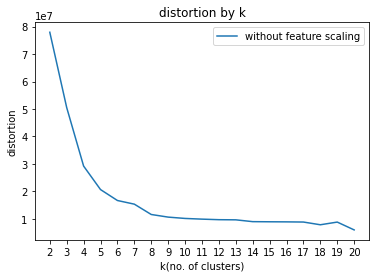

In [75]:
if NOTEBOOK:
    ## TODO your code here ##

    scores = test_cluster_size(X,20)
    k = range(2, len(scores)+2)
    plt.plot(k, scores,label="without feature scaling")
    plt.xticks(k)
    plt.title("distortion by k")
    plt.xlabel("k(no. of clusters)")
    plt.ylabel("distortion")
    plt.legend()
    ## TODO end ##

## **3.5. [3 pts, manually graded] Plot distortion vs. k (with feature scaling)** 

What we just did was running k-means clustering over the dataset X without any feature scaling. This time, we will rescale each feature to the standard range of (0,1) before passing it to k-means and computing the distortion.

Use `sklearn.preprocessing.MinMaxScaler` ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)) and scale the dataset X before passing it to the `test_cluster_size` function. As before, plot distortion vs. different k values and add it in the written report. Use max_k = 20. Determine the best k value from this plot and also mention it in the written report. Make sure your plot has axes labels, legend and title.

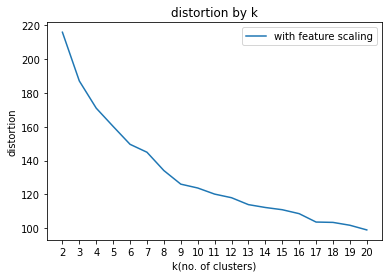

In [76]:
if NOTEBOOK:
    ## TODO your code here ##
    # Use min-max scaler to scale the dataset
    scaler = preprocessing.MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    scores = test_cluster_size(X_scaled,20)
    k = range(2, len(scores)+2)

    plt.plot(k, scores,label="with feature scaling")
    plt.xticks(k)
    plt.title("distortion by k")
    plt.xlabel("k(no. of clusters)")
    plt.ylabel("distortion")
    plt.legend()    

    ## TODO end ##

## **3.6. [4 pts, manually graded] Comments**

Answer these questions in the written report.

1. Why do you get different results with and without feature scaling?
2. Should you scale the features before fitting k-means? Why or why not?

# **4. Principal Component Analysis** 

## **4.1. [8 pts, manually graded] Exploring Effects of Different Princple Components in Linear Regression**
We have introduced you a way of dimension reduction, Principal Component Analysis, in class. Now, we would like to ask you to apply PCA from sklearn on the breast cancer dataset to observe its performance and interpret the major components.

In order to better compare the effects of PCA, we load the labels from the dataset.

Then, we will evaluate the performances of raw dataset and various numbers of pca components on LinearRegression classifier.

In the section, you are asked to draw a plot of test accuracies vs number of different principle components. The detailed instructions are included in the following cells.

Remember to **attach the plot** in your written submission, and also **make comments** about what you observe, explain the reason behind the trend, and what conclusion you could draw from the graph.

In [ ]:
# load the label from the dataset, which is a binary label 0/1 representing whether the cancer is benign or malignant

## TODO your code here ##
y = cancer_dataset['target']
## TODO end ##

Raw data has accuracy:  0.9414893617021277


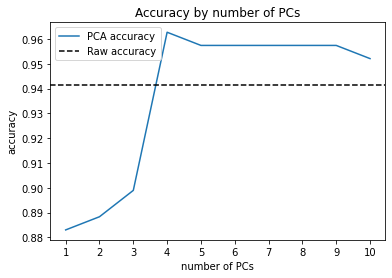

In [ ]:
# try raw data vs PCA data
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

## TODO your code here ##
# Step 1: split the data into train and test set by a test_size of 0.33.
np.random.seed(42) 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

# Step 2: Train a linear regression model using train set and predict on the test set.
# As the labels are binary, we should cast the predictions into binary labels as well. (Set predictions >=0.5 as 1)
lm = LinearRegression()
lm.fit(X_train, y_train)
y_pred = lm.predict(X_test)
y_pred[y_pred>=0.5] = 1
y_pred[y_pred<0.5] = 0
raw_accu = len(y_pred[y_pred == y_test])/len(y_pred)

# You might want to print out accuracy scores here
print("Raw data has accuracy: ", raw_accu)


# Step 3: Iterate the number of components from 1 to 10 (exclusive). 
# For each number of PCs, we are training a linear regression model and save its accuracy on the test set following the same style as above.
# Remeber to only fit the train set and not the test set. 
# You might want to store your accuracies in a list
accuracies = []

for i in range(1,11):
  pca = PCA(n_components = i)
  X_train_ = pca.fit_transform(X_train)
  X_test_ = pca.transform(X_test)
  lm = LinearRegression()
  lm.fit(X_train_, y_train)
  y_pred = lm.predict(X_test_)
  y_pred[y_pred>=0.5] = 1
  y_pred[y_pred<0.5] = 0
  accuracy = len(y_pred[y_pred == y_test])/len(y_pred)
  accuracies.append(accuracy)

# Step 4: Make a plot to compare accuracy vs number of PCs on Linear Regression for the test set.
# Add a black, dashed line for the test accuracy of linear regression by feeding the raw input data.
# Remeber to add x, y labels and title to your plot, and comment on your observations.

plt.plot(range(1,len(accuracies)+1), accuracies,label="PCA accuracy")
plt.axhline(y=raw_accu, color = 'black', linestyle = 'dashed',label="Raw accuracy")
plt.xticks(range(1,len(accuracies)+1))
plt.title("Accuracy by number of PCs")
plt.xlabel("number of PCs")
plt.ylabel("accuracy")
plt.legend()   
## TODO end ##

## **4.2. [5 pts] Understanding PCA**

### **4.2.1 [2 pts, autograded] Explained Ratio of PCA**
Given a threshold of explained ratio (0 < ratio < 1), compute the number of required PCs to reach the threshold.

In [ ]:
def select_n_principal_components(data, variation):
  ## TODO your code here ##
  i=1
  ratio=0
  while ratio<variation:
    pca = PCA(n_components = i)
    pca.fit(data)
    ratio = np.sum(pca.explained_variance_ratio_)
    i=i+1
  return i-1


  ## TODO end ##

In [ ]:
# PennGrader Grading Cell
if NOTEBOOK:
  student_ans = [select_n_principal_components(cancer_dataset['data'], 0.98), select_n_principal_components(cancer_dataset['data'], 0.99)]
  grader.grade(test_case_id = 'test_select_n_principal_components', answer = student_ans)

Correct! You earned 2/2 points. You are a star!

Your submission has been successfully recorded in the gradebook.


### **4.2.2 [3 pts, autograded] Composition of PCA**
In this section, we ask you to understand which features specifically in the dataset contribute to the important PCs. We ask that you select the best number of principle components you got from previous part and analyze its composition (as there are multiple components contributing to each PC, you only need to specify the **top three** features that are explained by these PCs together).

In [ ]:
## TODO your code here ##
pca = PCA(n_components = 4)
pca.fit(X_train)
eigenVec = pca.components_
eigenVal = pca.explained_variance_
contribution = np.empty([30,])
for i in range(30):
  v = np.zeros(30)
  v[i] = 1
  contribute = 0
  for d in range(4):
    dot = np.dot(eigenVec[d],v)
    contribute = contribute + dot*eigenVal[d]
  contribution[i] = contribute
index = np.argsort(contribution)[-3:]
print(cancer_dataset['feature_names'][index])
## TODO end ##

['area error' 'mean area' 'worst area']


## **4.3. [5 pts, manually graded] PCA and KMeans**
We first run PCA on the dataset for visualisation in 2D space. Note that k-means is actually being fit on the entire feature set. 

Next, call your k-means class on the dataset X and obtain the clusters. Make sure to populate the "clusters" variable here. We have provided the plotting code for you.

**Add these plots in the written report.**

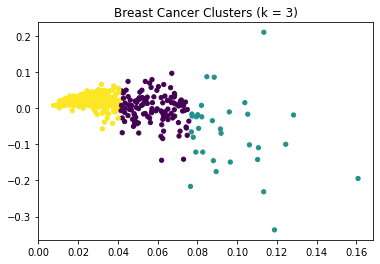

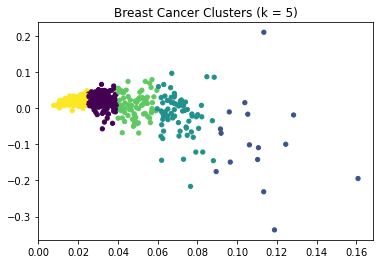

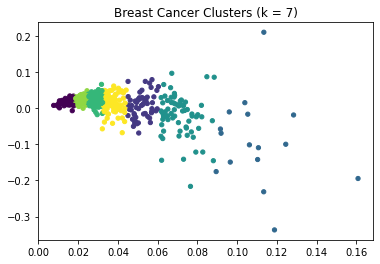

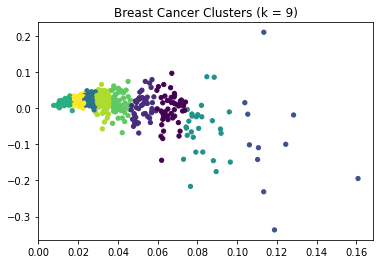

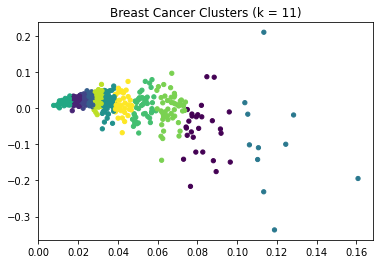

In [ ]:
if NOTEBOOK:
    # PCA for visualisation in 2D. 
    pca = PCA(n_components = 2)
    v = pca.fit(np.transpose(X)).components_

    for k in [3,5,7,9, 11]:

        clusters = np.zeros(X.shape[0])

        ## TODO your code here ##
        km = KMeans(k)
        clusters, centroids, _ = km.fit(X)


        ## TODO end ##

        plt.scatter(v[0], v[1], c=clusters, s=18)
        plt.title("Breast Cancer Clusters (k = "+str(k) + ")")
        plt.show()

## Submit to Gradescope
Congratulations! You've finished the homework. Don't forget to submit your final notebook on [Gradescope](gradescope.com).